<div style="display: flex; flex-direction: column; align-items: center; font-family: 'Arial';">
    <h1 style="color: #2c3e50;">
        <strong>Predicción de la Cantidad de Alumnos que Ingresan por un Pasillo de la UNI</strong>
    </h1>
    <hr style="width: 100%; border: 1px solid #3498db;">    
    <h2 style="color: #16a085;">
        Práctica Calificada de Computación Gráfica - Universidad Nacional de Ingeniería
    </h2>    
    <div style="display: flex; width: 100%; justify-content: space-between; padding: 10px;">
        <div style="flex: 1; padding-right: 20px;">
            <h3 style="font-family: 'Courier New'; color: #8e44ad;">Integrantes:</h3>
            <ul style="list-style-type: circle;">
                <li><strong>Estudiante 1:</strong> <a href="" target="_blank" style="text-decoration: none; color: #2980b9;">Barrientos Cardenas, Gabriel Adrians</a></li>
                <li><strong>Estudiante 2:</strong> <a href="" target="_blank" style="text-decoration: none; color: #2980b9;">Del Rosario Sosa, Joshua Jean Paul</a></li>
                <li><strong>Estudiante 3:</strong> <a href="" target="_blank" style="text-decoration: none; color: #2980b9;">Yarleque Ramos, Gabriel Gerardo</a></li>
            </ul>
        </div>
        <div style="flex: 1; padding-left: 20px;">
            <h3 style="font-family: 'Courier New'; color: #16a085;">Curso:</h3>
            <h4 style="color: #2ecc71;">Computación Gráfica</h4>
        </div>
    </div>
    <hr style="width: 100%; border: 1px solid #8e44ad;">
    <div style="display: flex; flex-direction: column; align-items: center; text-align: justify; padding: 10px;">
        <h3 style="font-family: 'Courier New'; color: #16a085;">Descripción del Proyecto:</h3>
        <p style="color: #34495e;">
            En este cuaderno se desarrolla un modelo predictivo para estimar la cantidad de alumnos que ingresan por un pasillo en la Universidad Nacional de Ingeniería. Se utilizan técnicas de Machine Learning y visión computacional para analizar los datos recolectados a partir de sensores y cámaras, optimizando así el flujo de estudiantes en áreas de alto tráfico.
        </p>
    </div>



## Importación de Librerías

En este paso se importan las bibliotecas necesarias para realizar el procesamiento de video, manipulación de datos y análisis de imágenes.

In [1]:
import cv2
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt

### Carga de datos
Cargamos el archivo espacios.pkl, el cual contiene las posiciones predeterminadas donde se esperan detectar personas.

In [2]:
detector_persona = []
with open('espacios.pkl', 'rb') as file:
    detector_persona = pickle.load(file)


### Lectura de videos
Leemos los videos de los tres periodos: mañana, tarde y noche. Además, obtenemos las dimensiones del primer video, que servirán como referencia para redimensionar los otros videos.

In [3]:
# Leer los 3 videos (mañana, tarde y noche)
video1 = cv2.VideoCapture('video_1_temprano.mp4')
video2 = cv2.VideoCapture('video_2_tarde.mp4')
video3 = cv2.VideoCapture('video_3_noche.mp4')

# Obtener la resolución del primer video
ret1, frame1 = video1.read()
height1, width1, _ = frame1.shape  # Obtener altura y anchura del primer video


### Conversión a escala de grises

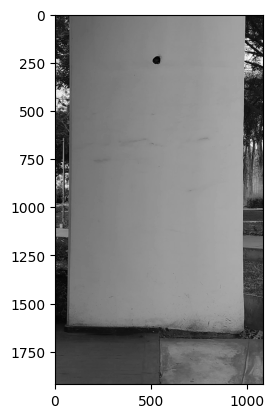

In [4]:
# Convertimos el primer fotograma a escala de grises para simplificar el análisis
img_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

# Mostramos el fotograma en escala de grises
plt.imshow(img_gray, cmap='gray')

In [5]:
# Mostramos el arreglo de la imagen en escala de grises
print(img_gray)

[[ 63  32  16 ...  12  14  44]
 [ 80  42  13 ...  22  23  47]
 [ 86  48  19 ...  21  20  34]
 ...
 [ 70  70  70 ... 100 100 100]
 [ 69  69  69 ... 101 101 101]
 [ 69  69  69 ...  97  97  97]]


### Aplicar umbral adaptativo

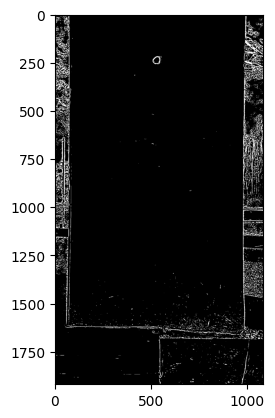

In [6]:
# Aplicamos el umbral adaptativo para destacar los objetos de interés
img_threshold = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 16)

# Mostramos la imagen umbralizada
plt.imshow(img_threshold, cmap='gray')

### Aplicar filtro de mediana

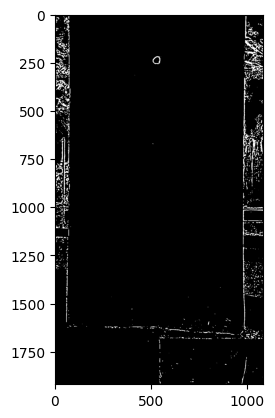

In [7]:
# Aplicamos un filtro de mediana para reducir el ruido en la imagen
img_median = cv2.medianBlur(img_threshold, 5)

# Mostramos la imagen después de aplicar el filtro de mediana
plt.imshow(img_median, cmap='gray')

### Dilatar la imagen

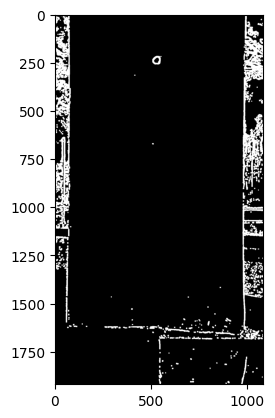

In [8]:
# Creamos un kernel para dilatar la imagen y expandir las áreas blancas
kernel = np.ones((5, 5), np.int8)
img_dilate = cv2.dilate(img_median, kernel)

# Mostramos la imagen dilatada
plt.imshow(img_dilate, cmap='gray')

# Procesamiento de Imágenes y Detección de Objetos

A continuación, se describen los pasos clave del procesamiento de imágenes y la detección de objetos:
1. **Conversión a escala de grises**: Esto simplifica el procesamiento, ya que elimina la información de color.
2. **Umbralización adaptativa**: Resalta las áreas relevantes de la imagen, convirtiendo píxeles en blanco o negro.
3. **Aplicación de un filtro de mediana**: Elimina ruido en la imagen.
4. **Dilatar la imagen**: Expande las áreas blancas, lo cual facilita la detección de objetos.

```python
def process_video(img, detector_persona, objeto_contador, ref_white_pixels, objeto_detectado, video_num):
    # Convertir a escala de grises
    imgBN = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Aplicar umbral adaptativo
    imgTH = cv2.adaptiveThreshold(imgBN, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 16)
    # Aplicar filtro de mediana
    imgMedian = cv2.medianBlur(imgTH, 5)
    # Crear un kernel y aplicar dilatación
    kernel = np.ones((5, 5), np.int8)
    imgDil = cv2.dilate(imgMedian, kernel)

    # Detección de objetos
    for i, (x, y, w, h) in enumerate(detector_persona):
        x = x - 10
        y = y - 10
        w = w + 20
        h = h + 20
        espacio = imgDil[y:y+h, x:x+w]
        count = cv2.countNonZero(espacio)

        if i not in ref_white_pixels:
            ref_white_pixels[i] = count

        cv2.putText(img, f"Pixeles: {count}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 3)

        if count > ref_white_pixels[i] + 500:
            objeto_detectado = True
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 3)
            img_filename = f"detected_objects_video{video_num}/objeto_{objeto_contador + 1}.png"
            cv2.imwrite(img_filename, img)

        if objeto_detectado and count <= ref_white_pixels[i]:
            objeto_detectado = False
            objeto_contador += 1

    return img, objeto_contador, objeto_detectado


## Resultados de Detección de Personas

Los resultados del procesamiento de los videos fueron los siguientes:

- Cantidad de personas detectadas en la mañana: **14**
- Cantidad de personas detectadas en la tarde: **10**
- Cantidad de personas detectadas en la noche: **19**

A continuación, visualizaremos estos resultados y plantearemos un modelo predictivo para estimar la cantidad de personas en otros periodos de tiempo.


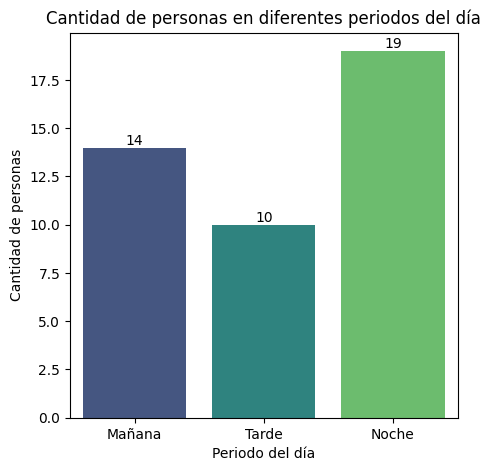

In [26]:
import seaborn as sns

# Datos de los resultados obtenidos
periodos = ['Mañana', 'Tarde', 'Noche']
cantidades = [14, 10, 19]

# Crear un gráfico de barras
plt.figure(figsize=(5, 5))
sns.barplot(x=periodos, y=cantidades , palette='viridis',hue=periodos)
plt.title('Cantidad de personas en diferentes periodos del día')
plt.ylabel('Cantidad de personas')
plt.xlabel('Periodo del día')

plt.text(0, cantidades[0], cantidades[0], ha='center', va='bottom')
plt.text(1, cantidades[1], cantidades[1], ha='center', va='bottom')
plt.text(2, cantidades[2], cantidades[2], ha='center', va='bottom')

plt.show()


Personas estimadas en 5 horas en la mañana: 840
Personas estimadas en 5 horas en la tarde: 600
Personas estimadas en 5 horas en la noche: 1140


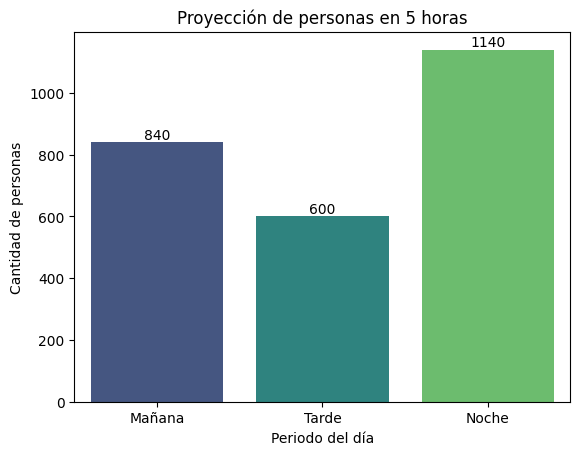

In [24]:
# Proyección de personas para 5 horas, considerando que se toman los resultados en 5 minutos

cant_mañana_5h = 14 * 12 * 5
cant_tarde_5h = 10 * 12 * 5
cant_noche_5h = 19 * 12 * 5

print(f"Personas estimadas en 5 horas en la mañana: {cant_mañana_5h}")
print(f"Personas estimadas en 5 horas en la tarde: {cant_tarde_5h}")
print(f"Personas estimadas en 5 horas en la noche: {cant_noche_5h}")

# Crear un gráfico de barras
sns.barplot(x=periodos, y=[cant_mañana_5h, cant_tarde_5h, cant_noche_5h], palette='viridis',hue=periodos)
plt.title('Proyección de personas en 5 horas')
plt.ylabel('Cantidad de personas')
plt.xlabel('Periodo del día')

# mostramos los valores
plt.text(0, cant_mañana_5h, cant_mañana_5h, ha='center', va='bottom')
plt.text(1, cant_tarde_5h, cant_tarde_5h, ha='center', va='bottom')
plt.text(2, cant_noche_5h, cant_noche_5h, ha='center', va='bottom')

plt.show()


In [45]:
error_prob = [ 0.7 , 0.2 , 0.1 ]
1 + np.random.choice( [0, 1, 2] , 1, p=error_prob)

array([1])

In [67]:
import numpy as np

# Considerar un error de ±10% para simular posibles errores de detección
error_factor = 2

# definir la matriz de error
error_prob = [ 0.7 , 0.2 , 0.1 ] # probabilidad de que haya 1 persona , 2 personas , 3 personas

# Proyección de personas para 5 horas, considerando que se toman los resultados en 5 minutos
cant_mañana_5h_error = 0
cant_tarde_5h_error = 0
cant_noche_5h_error = 0
for i in range(cant_mañana_5h):
    cant_mañana_5h_error += 1 + np.random.choice( [0, 1, 2] , 1, p=error_prob)
for i in range(cant_tarde_5h):
    cant_tarde_5h_error += 1 + np.random.choice( [0, 1, 2] , 1, p=error_prob)
for i in range(cant_noche_5h):
    cant_noche_5h_error += 1 + np.random.choice( [0, 1, 2] , 1, p=error_prob)

# Convertimos a entero
cant_mañana_5h_error = cant_mañana_5h_error[0]
cant_tarde_5h_error = cant_tarde_5h_error[0]
cant_noche_5h_error = cant_noche_5h_error[0]

print(f"Proyección con error en la mañana: {cant_mañana_5h_error}")
print(f"Proyección con error en la tarde: {cant_tarde_5h_error}")
print(f"Proyección con error en la noche: {cant_noche_5h_error}")


Proyección con error en la mañana: 1146
Proyección con error en la tarde: 821
Proyección con error en la noche: 1589


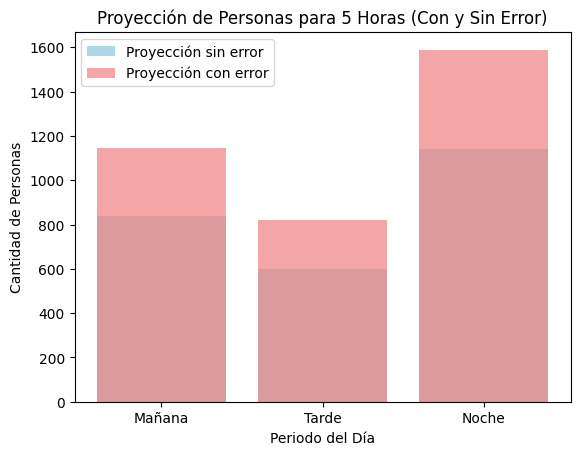

In [69]:
# Datos con proyección y con error
cantidades_5h = [cant_mañana_5h, cant_tarde_5h, cant_noche_5h]
cantidades_5h_error = [cant_mañana_5h_error, cant_tarde_5h_error, cant_noche_5h_error]

# Crear un gráfico comparativo
plt.bar(periodos, cantidades_5h, color='lightblue', label='Proyección sin error')
plt.bar(periodos, cantidades_5h_error, color='lightcoral', alpha=0.7, label='Proyección con error')
plt.title('Proyección de Personas para 5 Horas (Con y Sin Error)')
plt.xlabel('Periodo del Día')
plt.ylabel('Cantidad de Personas')
plt.legend()
plt.show()